# Testowanie różnych funkcji aktywacji
## [Zadanie](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org6058800)



Należy rozszerzyć istniejącą implementację sieci i metody uczącej o możliwość wyboru funkcji aktywacji:
- sigmoid,
- liniowa,
- tanh,
- ReLU.

Pytanie dodatkowe – czy wszyscy implementują dokładnie gradient dla funkcji ReLU?

Porównać szybkość uczenia i skuteczność sieci w zależności od liczby neuronów w poszczególnych warstwach i rodzaju funkcji aktywacji. Należy wziąć pod uwagę fakt, że różne funkcje aktywacji mogą dawać różną skuteczność w zależności od liczby neuronów i liczby warstw. Sprawdzić sieci z jedną, dwiema i trzema warstwami ukrytymi. Podobnie jak w poprzednim tygodniu, trzeba dostosować proces uczenia do pochodnych nowych funkcji aktywacji.

Przeprowadzić testy na zbiorach:

- regresja
    * steps-large,
    * multimodal-large
- klasyfikacja
    * rings5-regular
    * rings3-regular

In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["darkred", "mediumseagreen", "cornflowerblue", "purple"]) 

In [2]:
#### Miscellaneous classes

class Sigmoid:
    @staticmethod
    def activate(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def derivative(z):
        return Sigmoid.activate(z) * (1 - Sigmoid.activate(z))

class Linear:
    @staticmethod
    def activate(z):
        return z

    @staticmethod
    def derivative(z):
        return np.ones(shape = z.shape)
    
class MSECostFunction:
    @staticmethod
    def cost(y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true
    
class SoftMax:
    @staticmethod
    def activate(z):
        e_x = np.exp(z - np.max(z))
        return e_x / e_x.sum(axis=0, keepdims=True)
    
    @staticmethod
    def derivative(z):
        return None

class Tanh:
    @staticmethod
    def activate(z):
        return np.tanh(z)
    
    @staticmethod
    def derivative(z):
        return 1 - np.power(np.tanh(z), 2)
    
class ReLU:
    @staticmethod
    def activate(z):
        return np.maximum(0, z)
    
    # Not everyone implements the exact gradient for the ReLU function
    # due to the non-differentiability of this function at 0 
    @staticmethod
    def derivative(z):
        dr = np.array(z)
        dr[dr>0] = 1
        dr[dr<0] = 0
        # non-differentiability at 0
        eps = 1e-5
        dr[dr==0] = eps
        return dr

### Neural network initialization

In [3]:
class MLP:

    def __init__(self, layers, initial_dist, activation_functions, cost_function, softmax):
        """
        Presence of at least one hidden layer is an accompanying assumption        

        Takes:        
        layers - list of numbers of neurons in subsequent layers
        activation_functions - list of names of functions ie ('sigmoid', 'linear')

        Remarks: 
            - Length of layers list should be equal to length of activation_functions list + 1 
            - The biases and weights for the network are initialized randomly, using continuous uniform 
              distribution with certain bounds between 0 and 1 or -1 and 1 or Gaussian distribution with mean 0, 
              and variance 1.
        """
        
        self.layers = layers
        self.n_layers = len(layers)
        self.weights = []
        self.biases = []
        self.weights_bias_init(initial_dist)

        self.activation_functions = []
        self.activation_functions_derivatives_per_layer = []
        for fun in activation_functions:
            self.activation_functions.append(fun.activate)
            self.activation_functions_derivatives_per_layer.append(fun.derivative)

        self.cost_function = cost_function
        self.softmax = softmax

        if softmax:
            self.activation_functions[-1] = activation_functions[-1].activate
            
    def weights_bias_init(self, initial_dist):
        if initial_dist == "gaussian":
            self.biases = [np.random.normal(size=(y, 1)) for y in self.layers[1:]]
            self.weights = [np.random.normal(size=(y, x)) for x, y in zip(self.layers[:-1], self.layers[1:])]
            
        elif initial_dist == "uniform":
            self.biases = [np.random.uniform(-1, 1, size=(y, 1)) for y in self.layers[1:]]
            self.weights = [np.random.uniform(-1, 1, size=(y, x)) for x, y in zip(self.layers[:-1], self.layers[1:])]
            
        # Due to poor network performance with gaussian and uniform distributions in classification 
        # problems, I decided to implement xavier initialization 
        elif initial_dist == "xavier":
            self.biases = [np.random.uniform(-math.sqrt(6)/ math.sqrt(self.layers[i] + self.layers[i + 1]),
                    math.sqrt(6)/ math.sqrt(self.layers[i] + self.layers[i + 1]),size=(self.layers[i + 1], 1))
                for i in range(self.n_layers - 1)]
            self.weights = [np.random.uniform(-math.sqrt(6)/ math.sqrt(self.layers[i] + self.layers[i + 1]),
                    math.sqrt(6)/ math.sqrt(self.layers[i] + self.layers[i + 1]), size=(y, x))
                for x, y, i in zip(self.layers[:-1], self.layers[1:], range(self.n_layers))]
        else:
            self.biases = [np.random.uniform(0, 1, size=(y, 1)) for y in self.layers[1:]]
            self.weights = [np.random.uniform(0, 1, size=(y, x)) for x, y in zip(self.layers[:-1], self.layers[1:])]


    def forward(self, x):
        """
        Returns the output of the network if x is an input.
        """
        flat_values = []
        activation_values = [np.copy(x)]
        for w, b, f in zip(self.weights, self.biases, self.activation_functions):
            flat_values.append(w.dot(activation_values[-1]) + b)
            activation_values.append(f(flat_values[-1]))
        return (flat_values, activation_values)
            
            
    def backprop(self, x_batch, y_batch):
        """
        Function performing backpropagation
        Returns nabla_b and nabla_w representing the
        derivatives by weights and biases respectively. 
        nabla_b and nabla_w are calculated layer-by-layer.
        """ 
        (flat_values, activation_values) = self.forward(x_batch)
        errors = [None] * len(self.weights)
        
        
        if not self.softmax:
            errors[-1] = (-self.cost_function.derivative(y_batch, activation_values[-1])) * self.activation_functions_derivatives_per_layer[-1](flat_values[-1])
        else:
            errors[-1] = y_batch - activation_values[-1]
            
        for i in reversed(range(len(errors) - 1)):
            errors[i] = self.weights[i + 1].T.dot(errors[i + 1]) * self.activation_functions_derivatives_per_layer[i](flat_values[i])
        batch_size = y_batch.shape[1]
        d_b = [e.dot(np.ones((batch_size, 1))) / float(batch_size) for e in errors]
        d_w = [e.dot(activation_values[i].T) / float(batch_size) for i, e in enumerate(errors)]
        return (d_w, d_b) 
    
    def predict(self, x):
        return self.forward(x.T)[1][-1].T
            

    def train(self, x, y, batches_num = 10, epochs = 100, eta = 10 ** (-3)):
        """
        Updates weights and biases based on the output using backpropagation.
        
        The version with the update of the scales after the presentation 
        of all patterns and the version with the update after the presentation
        of subsequent portions (batch) was performed within one function. 
        To get the first variant of operation as batch size the number of all
        observations should be given.
        """
        for e in range(epochs):
            shuffled_indexes = np.random.permutation(x.shape[0])
            updated_x = x.copy()[shuffled_indexes]
            updated_y = y.copy()[shuffled_indexes]

            updated_x = np.array_split(updated_x, batches_num)
            updated_y = np.array_split(updated_y, batches_num)

            for batch_num in range(batches_num):
                x_batch = updated_x[batch_num].T
                y_batch = updated_y[batch_num].T
                d_w, d_b = self.backprop(x_batch, y_batch)
                self.weights = [w + eta * dw for w, dw in zip(self.weights, d_w)]
                self.biases = [b + eta * db for b, db in zip(self.biases, d_b)]

    def trainWithMomentum(self, x, y, batches_num = 10, epochs = 100, eta = 10 ** (-3)):

        for e in range(epochs):
            momentum_b = [np.zeros(b.shape) for b in self.biases]
            momentum_w = [np.zeros(w.shape) for w in self.weights]

            shuffled_indexes = np.random.permutation(x.shape[0])
            updated_x = x.copy()[shuffled_indexes]
            updated_y = y.copy()[shuffled_indexes]

            updated_x = np.array_split(updated_x, batches_num)
            updated_y = np.array_split(updated_y, batches_num)

            for batch_num in range(batches_num):
                x_batch = updated_x[batch_num].T
                y_batch = updated_y[batch_num].T
                d_w, d_b = self.backprop(x_batch, y_batch)

                momentum_b = [db + mb * lambda_val for mb, db in zip(momentum_b, d_b)]
                momentum_w = [dw + mw * lambda_val for mw, dw in zip(momentum_w, d_w)]

                self.biases = [b + mb * eta for b, mb in zip(self.biases, momentum_b)]
                self.weights = [w + mw * eta for w, mw in zip(self.weights, momentum_w)]

    def trainWithRMSProp(self, x, y, beta, batches_num = 10, epochs = 100, eta = 10 ** (-3)):

        for e in range(epochs):
            grad_b = [np.zeros(b.shape) for b in self.biases]
            grad_w = [np.zeros(w.shape) for w in self.weights]

            shuffled_indexes = np.random.permutation(x.shape[0])
            updated_x = x.copy()[shuffled_indexes]
            updated_y = y.copy()[shuffled_indexes]

            updated_x = np.array_split(updated_x, batches_num)
            updated_y = np.array_split(updated_y, batches_num)

            for batch_num in range(batches_num):
                x_batch = updated_x[batch_num].T
                y_batch = updated_y[batch_num].T
                d_w, d_b = self.backprop(x_batch, y_batch)

                grad_b = [(1 - beta) * np.square(db) + beta * gb for gb, db in zip(grad_b, d_b)]
                grad_w = [(1 - beta) * np.square(dw) + beta * gw for gw, dw in zip(grad_w, d_w)]

                self.biases = [b + np.divide(db, np.sqrt(gb) + 10e-8) * eta for b, gb, db in zip(self.biases, grad_b, d_b)]
                self.weights = [w + np.divide(dw, np.sqrt(gw) + 10e-8) * eta for w, gw, dw in zip(self.weights, grad_w, d_w)]

In [4]:
# Universal parameters settings
activate_functions_names = ["Linear", "ReLU", "Tanh", "Sigmoid"]
number_of_batches = 10
upper_epoch_bound = 1000

## 1. Regression


### 1.1. Steps-Large dataset

In [5]:
steps_large_train = pd.read_csv('../data/mio1/regression/steps-large-training.csv')[["x", "y"]]
steps_large_test = pd.read_csv('../data/mio1/regression/steps-large-test.csv')[["x", "y"]]

# Data preprocessing
x_test = steps_large_test["x"].to_numpy().reshape(-1, 1)
y_test = steps_large_test["y"].to_numpy().reshape(-1, 1)

y_train = steps_large_train["y"].to_numpy().reshape(-1, 1)
x_train = steps_large_train["x"].to_numpy().reshape(-1, 1)

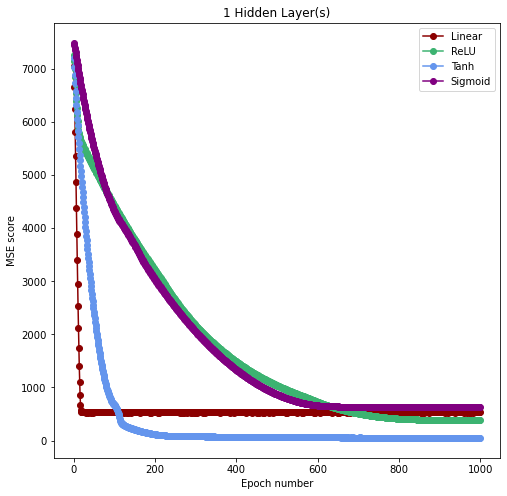

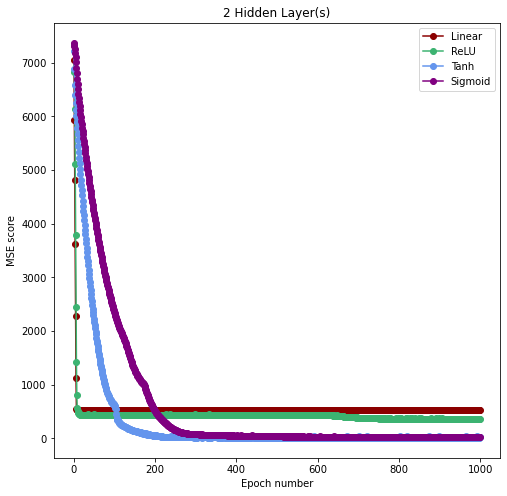

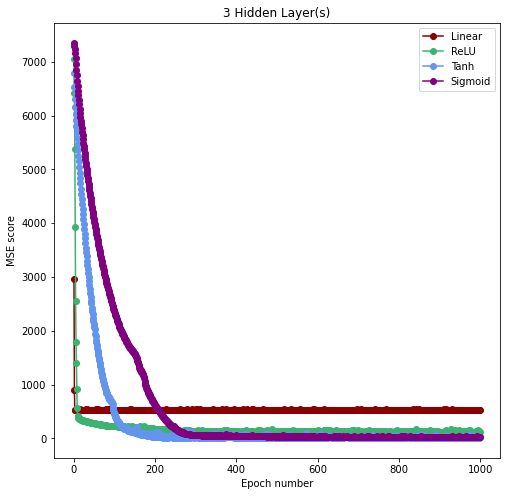

In [6]:
# Universal parameters settings
n_layers_list = [[1, 5, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1]]
etas = [0.01, 0.01, 0.01, 0.01]

# Performances comparison
for n_layers in n_layers_list:
    mse_scores = []
    
    linear_activations = [Linear for i in range(len(n_layers) - 1)]
    relu_activations = [ReLU for i in range(len(n_layers) - 2)] + [Linear]
    tanh_activations = [Tanh for i in range(len(n_layers) - 2)] + [Linear]
    sigmoid_activations = [Sigmoid for i in range(len(n_layers) - 2)] + [Linear]
    
    activations = [linear_activations, relu_activations, tanh_activations, sigmoid_activations]

    stepsLarge = MLP(n_layers, "gaussian", activations[0], MSECostFunction, False)

    initial_weights = stepsLarge.weights.copy()
    initial_biases = stepsLarge.biases.copy()
    
    for activation_function, eta in zip(activations, etas):
        stepsLarge = MLP(n_layers, "gaussian", activation_function, MSECostFunction, False)
        mse_values = []
        epoch_number = 0
        stepsLarge.biases = initial_biases
        stepsLarge.weights = initial_weights
        
        while epoch_number < upper_epoch_bound:

            stepsLarge.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.90)

            prediction = stepsLarge.predict(x_test)
            mse_value = np.mean((y_test - prediction) ** 2)
            mse_values.append(mse_value)
            epoch_number += 1
            
        mse_scores.append(mse_values)
    
    fig = plt.figure(figsize = (8, 8))
    ax1 = fig.add_subplot(111)
    x_axis = [i for i in range(upper_epoch_bound)]
    for current_name, current_score in zip(activate_functions_names, mse_scores):
        ax1.plot(x_axis, current_score, '-o', label=current_name)
    plt.legend(loc="upper right")
    plt.title(str(len(n_layers) - 2) + " Hidden Layer(s)")
    plt.xlabel("Epoch number")
    plt.ylabel("MSE score")
    plt.show()

### 1.2. Multimodal-Large dataset

In [7]:
multimodal_large_train = pd.read_csv('../data/mio1/regression/multimodal-large-training.csv')[["x", "y"]]
multimodal_large_test = pd.read_csv('../data/mio1/regression/multimodal-large-test.csv')[["x", "y"]]

# Data preprocessing
x_test = multimodal_large_test["x"].to_numpy().reshape(-1, 1)
y_test = multimodal_large_test["y"].to_numpy().reshape(-1, 1)

y_train = multimodal_large_train["y"].to_numpy().reshape(-1, 1)
x_train = multimodal_large_train["x"].to_numpy().reshape(-1, 1)

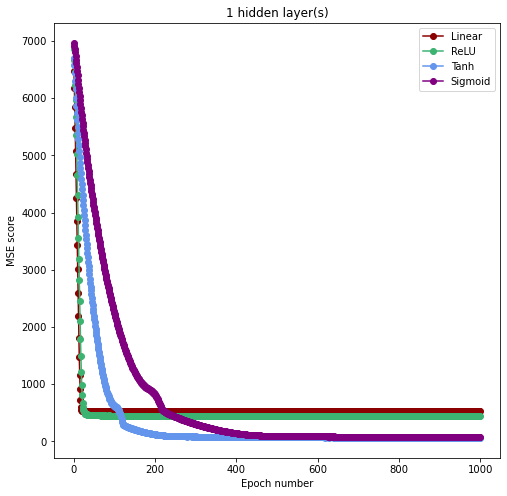

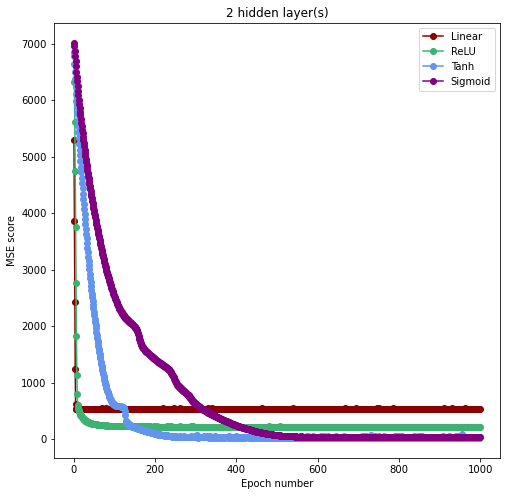

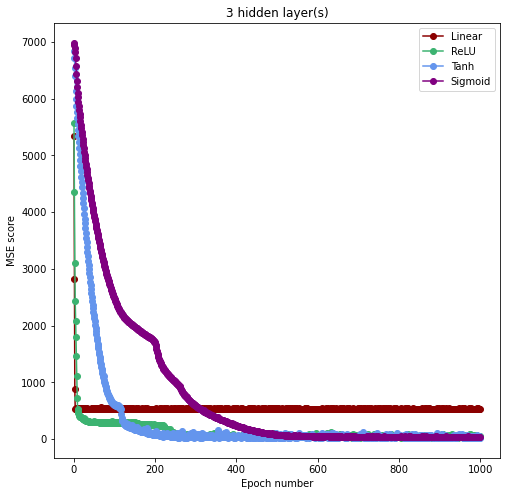

In [8]:
# Universal parameters settings
n_layers_list = [[1, 5, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1]]
etas = [0.01, 0.01, 0.01, 0.01]

# Performances comparison
for n_layers in n_layers_list:
    mse_scores = []
    
    linear_activations = [Linear for i in range(len(n_layers) - 1)]
    relu_activations = [ReLU for i in range(len(n_layers) - 2)] + [Linear]
    tanh_activations = [Tanh for i in range(len(n_layers) - 2)] + [Linear]
    sigmoid_activations = [Sigmoid for i in range(len(n_layers) - 2)] + [Linear]
    
    activations = [linear_activations, relu_activations, tanh_activations, sigmoid_activations]

    multimodal = MLP(n_layers, "gaussian", activations[0], MSECostFunction, False)

    initial_weights = multimodal.weights.copy()
    initial_biases = multimodal.biases.copy()
    
    for activation_function, eta in zip(activations, etas):
        multimodal = MLP(n_layers, "gaussian", activation_function, MSECostFunction, False)
        mse_values = []
        epoch_number = 0
        multimodal.biases = initial_biases
        multimodal.weights = initial_weights
        
        while epoch_number < upper_epoch_bound:

            multimodal.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.90)

            prediction = multimodal.predict(x_test)
            mse_value = np.mean((y_test - prediction) ** 2)
            mse_values.append(mse_value)
            epoch_number += 1
            
        mse_scores.append(mse_values)
    
    fig = plt.figure(figsize = (8, 8))
    ax1 = fig.add_subplot(111)
    x_axis = [i for i in range(upper_epoch_bound)]
    for current_name, current_score in zip(activate_functions_names, mse_scores):
        ax1.plot(x_axis, current_score, '-o', label=current_name)
    plt.legend(loc="upper right")
    plt.title(str(len(n_layers) - 2) + " hidden layer(s)")
    plt.xlabel("Epoch number")
    plt.ylabel("MSE score")
    plt.show()

## 2. Classification

### 2.1. Rings3-regular dataset

In [14]:
rings3_train = pd.read_csv("../data/mio1/classification/rings3-regular-training.csv")
rings3_test = pd.read_csv("../data/mio1/classification/rings3-regular-test.csv")

# Data preprocessing
x_test = rings3_test[["x", "y"]].to_numpy()
x_train = rings3_train[["x", "y"]].to_numpy()

y_test = rings3_test["c"] * 1
n_values = np.max(y_test) + 1
y_test = np.eye(n_values)[y_test.T]

y_train = rings3_train["c"] * 1
n_values = np.max(y_train) + 1
y_train = np.eye(n_values)[y_train.T]

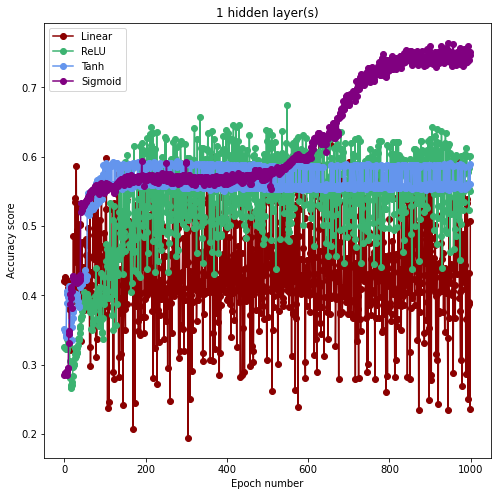

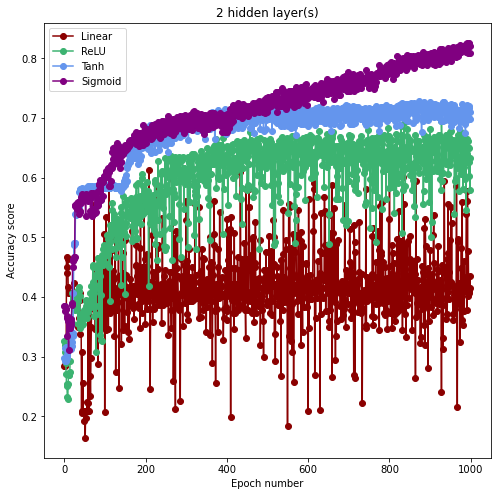

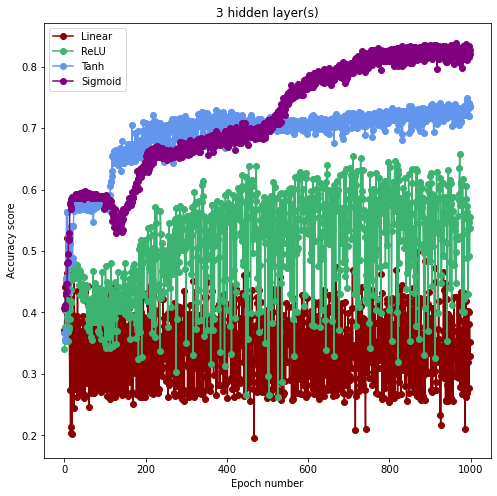

In [27]:
# Universal parameters settings
n_layers_list = [[2, 10, 3], [2, 10, 10, 3], [2, 10, 10, 10, 3]]
etas = [0.001, 0.001, 0.001, 0.001]

# Performances comparison
for n_layers in n_layers_list:
    accuracy_scores = []
    
    linear_activations = [Linear for i in range(len(n_layers) - 1)]
    relu_activations = [ReLU for i in range(len(n_layers) - 2)] + [Linear]
    tanh_activations = [Tanh for i in range(len(n_layers) - 2)] + [Linear]
    sigmoid_activations = [Sigmoid for i in range(len(n_layers) - 2)] + [Linear]
    
    activations = [linear_activations, relu_activations, tanh_activations, sigmoid_activations]

    rings3 = MLP(n_layers, "gaussian", activations[0], MSECostFunction, True)

    initial_weights = rings3.weights.copy()
    initial_biases = rings3.biases.copy()
    
    for activation_function, eta in zip(activations, etas):
        rings3 = MLP(n_layers, "gaussian", activation_function, MSECostFunction, True)
        accuracy_values = []
        epoch_number = 0
        rings3.biases = initial_biases
        rings3.weights = initial_weights
        
        while epoch_number < upper_epoch_bound:

            rings3.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches,beta = 0.90)

            prediction = rings3.predict(x_test)
            prediction = np.argmax(prediction, axis = 1)

            accuracy_value = accuracy_score(np.argmax(y_test, axis = 1), prediction)
            accuracy_values.append(accuracy_value)
            epoch_number += 1
            
        accuracy_scores.append(accuracy_values)
    
    fig = plt.figure(figsize = (8, 8))
    ax1 = fig.add_subplot(111)
    x_axis = [i for i in range(upper_epoch_bound)]
    for current_name, current_score in zip(activate_functions_names, accuracy_scores):
        ax1.plot(x_axis, current_score, '-o', label=current_name)
    plt.legend(loc="upper left")
    plt.title(str(len(n_layers) - 2) + " hidden layer(s)")
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy score")
    plt.show()

### 2.2. Rings5-regular dataset

In [11]:
rings5_train = pd.read_csv("../data/mio1/classification/rings5-regular-training.csv")
rings5_test = pd.read_csv("../data/mio1/classification/rings5-regular-test.csv")

# Data preprocessing
x_test = rings5_test[["x", "y"]].to_numpy()
x_train = rings5_train[["x", "y"]].to_numpy()

y_test = rings5_test["c"] * 1
n_values = np.max(y_test) + 1
y_test = np.eye(n_values)[y_test.T]

y_train = rings5_train["c"] * 1
n_values = np.max(y_train) + 1
y_train = np.eye(n_values)[y_train.T]

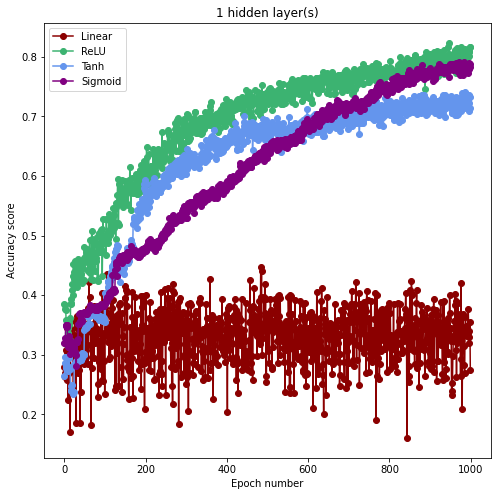

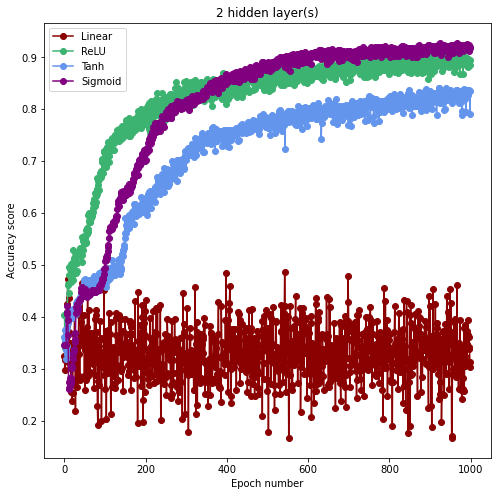

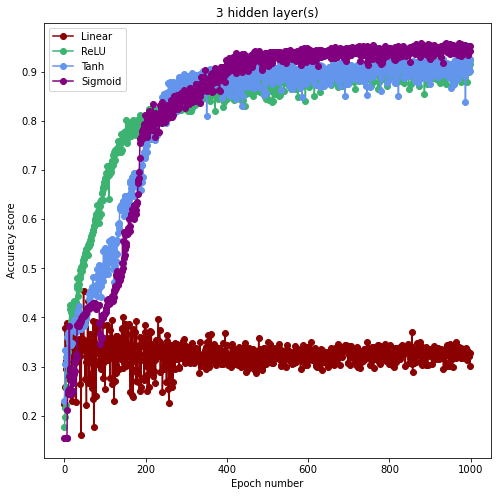

In [12]:
# Universal parameters settings
n_layers_list = [[2, 10, 5], [2, 10, 10, 5], [2, 10, 10, 10, 5]]
etas = [0.001, 0.001, 0.001, 0.001]

# Performances comparison
for n_layers in n_layers_list:
    accuracy_scores = []
    
    linear_activations = [Linear for i in range(len(n_layers) - 2)] + [SoftMax]
    relu_activations = [ReLU for i in range(len(n_layers) - 2)] + [SoftMax]
    tanh_activations = [Tanh for i in range(len(n_layers) - 2)] + [SoftMax]
    sigmoid_activations = [Sigmoid for i in range(len(n_layers) - 2)] + [SoftMax]
    
    activations = [linear_activations, relu_activations, tanh_activations, sigmoid_activations]

    rings5 = MLP(n_layers, "xavier", activations[0], MSECostFunction, True)

    initial_weights = rings5.weights.copy()
    initial_biases = rings5.biases.copy()
    
    for activation_function, eta in zip(activations, etas):
        rings5 = MLP(n_layers, "xavier", activation_function, MSECostFunction, True)
        accuracy_values = []
        epoch_number = 0
        rings5.biases = initial_biases
        rings5.weights = initial_weights
        
        while epoch_number < upper_epoch_bound:

            rings5.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.90)

            prediction = rings5.predict(x_test)
            prediction = np.argmax(prediction, axis = 1)

            accuracy_value = accuracy_score(np.argmax(y_test, axis = 1), prediction)
            accuracy_values.append(accuracy_value)
            epoch_number += 1
            
        accuracy_scores.append(accuracy_values)
    
    fig = plt.figure(figsize = (8, 8))
    ax1 = fig.add_subplot(111)
    x_axis = [i for i in range(upper_epoch_bound)]
    for current_name, current_score in zip(activate_functions_names, accuracy_scores):
        ax1.plot(x_axis, current_score, '-o', label=current_name)
    plt.legend(loc="upper left")
    plt.title(str(len(n_layers) - 2) + " hidden layer(s)")
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy score")
    plt.show()